# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

## Using the photonic-hamiltonian package

### Load the data file

Before using the package, please make sure that the data is converted into .nc format

Our io_data.py script provides the $\textbf{load_data(filename)}$ function which exports the data in .nc format into an xarray with data labels 'normf', 'y1', 'y2', 'y3', 'y4', which indicates four repeating measurement results

In [50]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor

from photonic_hamiltonian.inference import io_data
#load an example data file, data courtersy: Fan Du
real_data = io_data.load_data('photonic_hamiltonian\data\expdata_singleKspectrum.nc')

In [51]:
from pytensor import tensor as pt
import numpy as np
import pymc as pm
import pytensor

def prediction_model(theta, x):
    """
    Calculate the multi Lorentzian peak curve fit using a set of given fitting parameters

    Parameters
    ----------
    x (NumPy array):
        The array of normalized frequency
    theta (list of Floats or PyTensors):
        The list of fitting parameters, in the order u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4
        
    Return
    ---------
    line (NumPy array or PyTensors):
        The array of corresponding fitted intensity
    """
    #for our 4-basis Hamiltonian, the parameters include
    #energy and its deviation of uncoupled modes: e0, de
    #interaction-between-modes terms u11, u20;
    #background A0
    #heights of 4 peaks A1, A2, A3, A4
    #widths of 4 peaks W1, W2, W3, W4
    u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4 = theta

    #energy of uncoupled modes
    ex = e0 + de   # for k = (0, +-0.05) the energy of uncoupled slab mode 1 
    ey = e0 - de   # for k = (+-0.05,0) the energy of uncoupled slab mode 2
    
    #Hamiltonian matrix
    ham_np = np.array([[ex,u11,u20,u11],
                       [u11,ey,u11,u20],
                       [u20,u11,ey,u11],
                       [u11,u20,u11,ex]])
    An_np = np.array([A1,A2,A3,A4])
    Qn_np = np.array([Q1,Q2,Q3,Q4])
    
    #Diagonalize the matrix in two cases
    #if diagonalize a Numpy array matrix object
    if isinstance(theta[0], pt.TensorVariable) == False:
        Cn_np = np.real(np.linalg.eigvals(ham_np))
        Cn_np = np.sort(Cn_np)
        Wn_np = Cn_np/Qn_np
        #calculate normalized intensity
        line_each = [(Ai * Wi**2) / ((x- Ci)**2 + Wi**2) for Ai, Ci, Wi in zip(An_np, Cn_np, Wn_np)]
        line = np.sum(line_each, axis=0) + A0
    #if diagonalize a PyTensor matrix object
    else:
        ham = pytensor.shared(np.zeros((4,4)))
        for row in range(4):
            for col in range(4):
                ham = pt.set_subtensor(ham[row, col], ham_np[row, col])

        #peak heights, peak positions, and peak widths
        An = pytensor.shared(np.zeros(4))
        Qn = pytensor.shared(np.zeros(4))
        for col in range(4):
            An = pt.set_subtensor(An[col], An_np[col])
            Qn = pt.set_subtensor(Qn[col], Qn_np[col])

        Cn = pt.nlinalg.eigh(ham)[0]
        Cn = pt.sort(Cn)
        Wn = Cn/Qn
        #loop over An, Cn, Wn to calculate the cumulative sum of Lorentzians
        # output, updates = pytensor.scan(fn=lambda An, Cn, Wn: An * pt.sqr(Wn) / (pt.sqr(x-Cn) + pt.sqr(Wn)),
        #                                sequences=[An, Cn, Wn],
        #                                outputs_info=None)
        # line = A0 + output.sum()
        line = A0 + An[0] * pt.sqr(Wn[0]) / (pt.sqr(x-Cn[0]) + pt.sqr(Wn[0])) + An[1] * pt.sqr(Wn[1]) / (pt.sqr(x-Cn[1]) + pt.sqr(Wn[1])) + An[2] * pt.sqr(Wn[2]) / (pt.sqr(x-Cn[2]) + pt.sqr(Wn[2])) + An[3] * pt.sqr(Wn[3]) / (pt.sqr(x-Cn[3]) + pt.sqr(Wn[3]))
    
    return line

def Hamiltonian_model(data, priors):
    """
    returns a pymc model to infer the parameters for a 4-basis Hamiltonian.
    The piors on all parameters are either Uniform, Gaussian, or Exponential
    The likelihood ~ Gaussian(line, sigma_y)
    Line is the expectation value obtained by taking the sum of background and 4 Lorentzians peaked
    at the eigenvalues of 4x4 Hamiltonian matrix
    
    Parameters:
        data: the data set of a single-momentum spectrum 
              (DataArray with 'normf': frequency, 'spectrum': intensity, and 'spectrum_std': intensity uncertainty)
        priors: the prior types and prior coefficients of all parameters we want to infer
              (dict mapping a string, name of the parameter, to a tuple (prior_type, [prior coefficients]))
        For example: {'param 1':('Uniform', [lower bound, upper bound]),
                    'param 2':('Gaussian', [mean, std])
                    'param 3':('Exponential', [mean]}
              
    Return:
        ham_model: the pymc model can be used to infer the parameters and their posterior
              (pymc Model object)
    
    """
    #extract data to numpy arrays
    freq = data['normf'].to_numpy()
    Nf = len(freq)
    namef = ['y1','y2','y3','y4'] #measurements are repeated 4 times
    intensity = np.zeros((4,Nf))
    intensity[:] = [data[namef[i]].to_numpy() for i in range(4)]
    
    #create the multi Lorentzian peak model
    ham_model = pm.Model()
    with ham_model:
        # Priors for unknown model parameters
        theta_list = []
        for i in list(priors.keys()):
            if priors[i][0] == 'Uniform':
                lower, upper = priors[i][1]
                theta_list.append(pm.Uniform(i, lower, upper))
            elif priors[i][0] == 'Normal':
                mean, std = priors[i][1]
                theta_list.append(pm.Normal(i, mean, std))
            elif priors[i][0] == 'Exponential':
                mean, = priors[i][1]
                theta_list.append(pm.Exponential(i, mean))
            else:
                raise ValueError('Invalid prior type')
    
        #input of the model prediction
        theta = pt.as_tensor_variable(theta_list[:-1])
        line = prediction_model(theta, freq)
        
        # Uncertainty of the intensity is also a parameter
        sigma_y = theta_list[-1]
        
        # Gaussian Likelihood of observations
        likelihood = pm.Normal('likelihood', mu = line, sigma = sigma_y*pt.sqrt(intensity), observed = intensity)
    return ham_model

We can plot this data to visualize how the four peaks look like in a real measurement

## 0.065

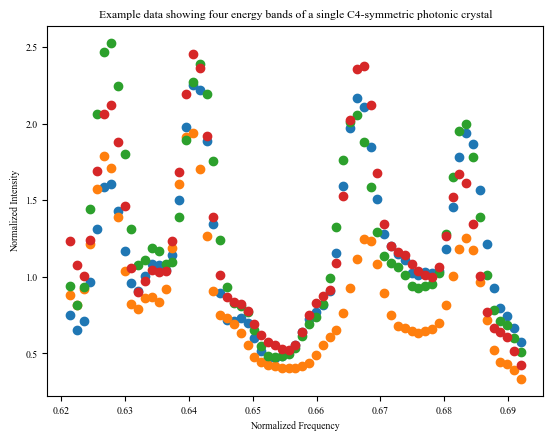

In [80]:
real_data = io_data.load_data('photonic_hamiltonian\data\expdata_singleKspectrum.nc')
freq = real_data['normf'].to_numpy()
intensity = np.zeros((4,len(freq)))
intensity[:] = [real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']]
plt.plot(freq, intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')
plt.show()

#### Inference on real data

Similar to what we did with the simulated data, we need to look at the raw data, guess the bounds for peak parameters and then sample with generative model.

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 119 seconds.


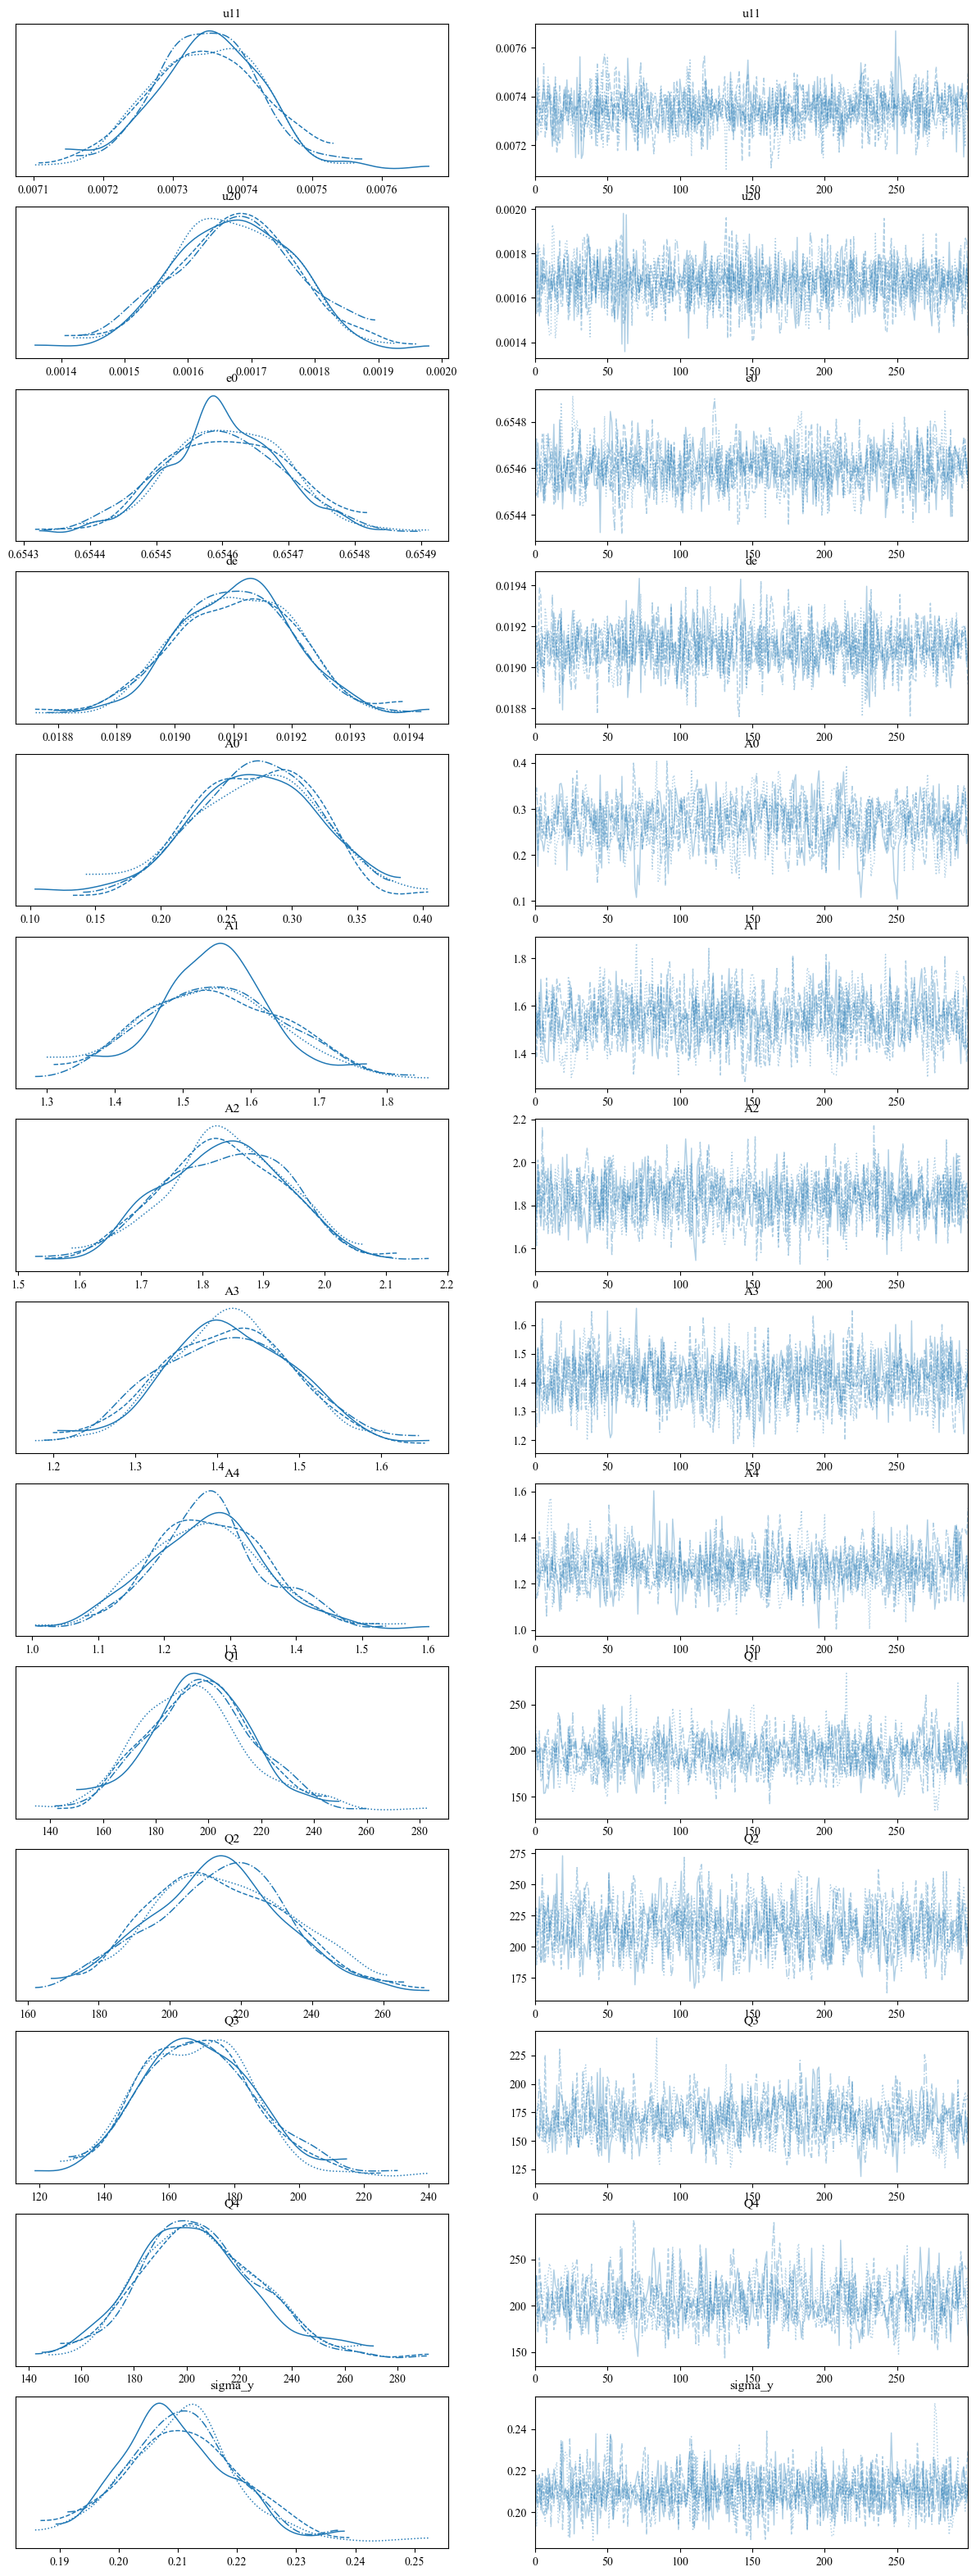

In [76]:
## attempt with more physical priors
#guess the prior bounds    
# k = 0.06
prior_A = [0.5, 2.5]
prior_W = [0.001, 0.03]
Q = [1/200]
priors_2 = {'u11':('Normal', [0.0074, 0.0002]),
               'u20':('Normal', [0.0017, 0.0001]),
               'e0':('Uniform', [0.64, 0.67]),
               'de':('Uniform', [0.005, 0.025]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', [1/1.6]),
               'A2':('Exponential', [1/1.6]),
               'A3':('Exponential', [1/1.6]),
               'A4':('Exponential', [1/1.6]),
               'Q1':('Exponential', Q ), 
               'Q2':('Exponential', Q ),
               'Q3':('Exponential', Q ),
               'Q4':('Exponential', Q ),
               'sigma_y':('Exponential', [1/0.2])}

#create the model 
ham_model = Hamiltonian_model(real_data, priors_2)
with ham_model:
    idata = pm.sample(300)

az.plot_trace(idata, figsize=(15,40));

mean         sd      hdi_3%     hdi_97%  mcse_mean   mcse_sd  \
u11        0.007348   0.000078    0.007192    0.007481   0.000002  0.000001   
u20        0.001673   0.000097    0.001497    0.001863   0.000002  0.000002   
e0         0.654605   0.000091    0.654439    0.654777   0.000002  0.000002   
de         0.019103   0.000104    0.018892    0.019278   0.000003  0.000002   
A0         0.270710   0.048490    0.177151    0.355577   0.001888  0.001336   
A1         1.546241   0.098688    1.358023    1.727185   0.003062  0.002166   
A2         1.837137   0.102234    1.652717    2.023757   0.002617  0.001851   
A3         1.413287   0.080715    1.259869    1.557974   0.002106  0.001490   
A4         1.268290   0.086314    1.119883    1.438871   0.002625  0.001873   
Q1       196.372241  19.887925  158.663154  232.636577   0.667727  0.472310   
Q2       214.611255  19.026267  179.769847  249.483198   0.636117  0.449949   
Q3       168.833318  17.218968  138.093084  201.836682   0.608841  0.430673   
Q4       205.028940  22.555463  162.222255  246.208254   0.772791  0.554433   
sigma_y    0.210249   0.009357    0.192926    0.227670   0.000234  0.000167   

            ess_bulk     ess_tail     r_hat  
u11      1552.228042   763.344296  0.999826  
u20      2046.256128   706.302708  1.002129  
e0       1392.853725   840.960887  1.003689  
de       1552.695630  1156.456325  1.001593  
A0        677.972854   706.409711  0.999904  
A1       1016.984640   681.453833  1.012070  
A2       1496.520926  1043.591884  1.003699  
A3       1472.610823  1035.064296  1.001105  
A4       1111.420147   823.507748  1.003132  
Q1        855.145912   703.145498  0.999896  
Q2        895.722245   961.818622  1.001791  
Q3        783.374954   737.955312  1.000392  
Q4        875.283913   992.999909  1.000307  
sigma_y  1631.828207   887.106951  1.002286

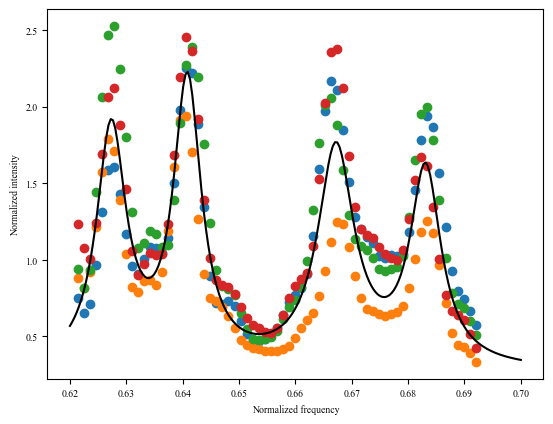

In [77]:
#summary the fitting results
summary = az.summary(idata, round_to=8)
display(summary)
#plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y = summary['mean'].values
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]
model_predictions = prediction_model(theta, np.linspace(0.62,0.70,200))
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(freq, intensity.T, 'o')
plt.plot(np.linspace(0.62,0.70,200), model_predictions,'k')

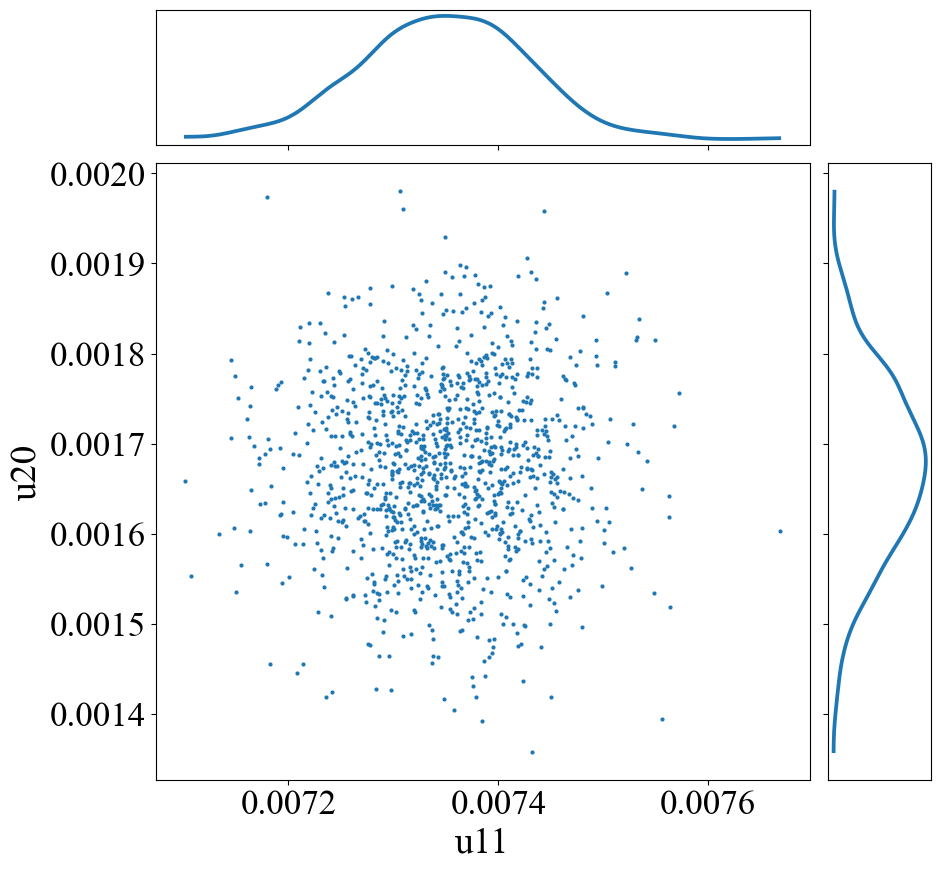

In [81]:
from matplotlib import rcParams
font = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size' : 7,
         }
confont = {
           'font.family' : 'serif',
           'mathtext.fontset':'stix',
           'font.serif':'Times New Roman',
           'font.size' : 7,
         }
rcParams.update(confont)
ff = az.plot_pair(idata,var_names=["u11", "u20"],marginals=True,figsize=(10, 10))
plt.savefig('k0p065_v2.png', dpi = 300,bbox_inches = 'tight')

In [82]:
az.to_netcdf(idata, 'idata_0p065.nc')

'idata_0p065.nc'

## 0.55

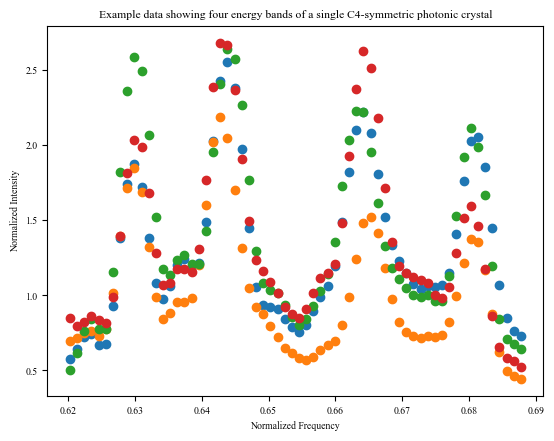

In [83]:
# load 0.55
real_data = io_data.load_data('photonic_hamiltonian\data\expdata4_GM0p055.nc')
freq = real_data['normf'].to_numpy()
intensity = np.zeros((4,len(freq)))
intensity[:] = [real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']]
plt.plot(freq, intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')
plt.show()

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 98 seconds.


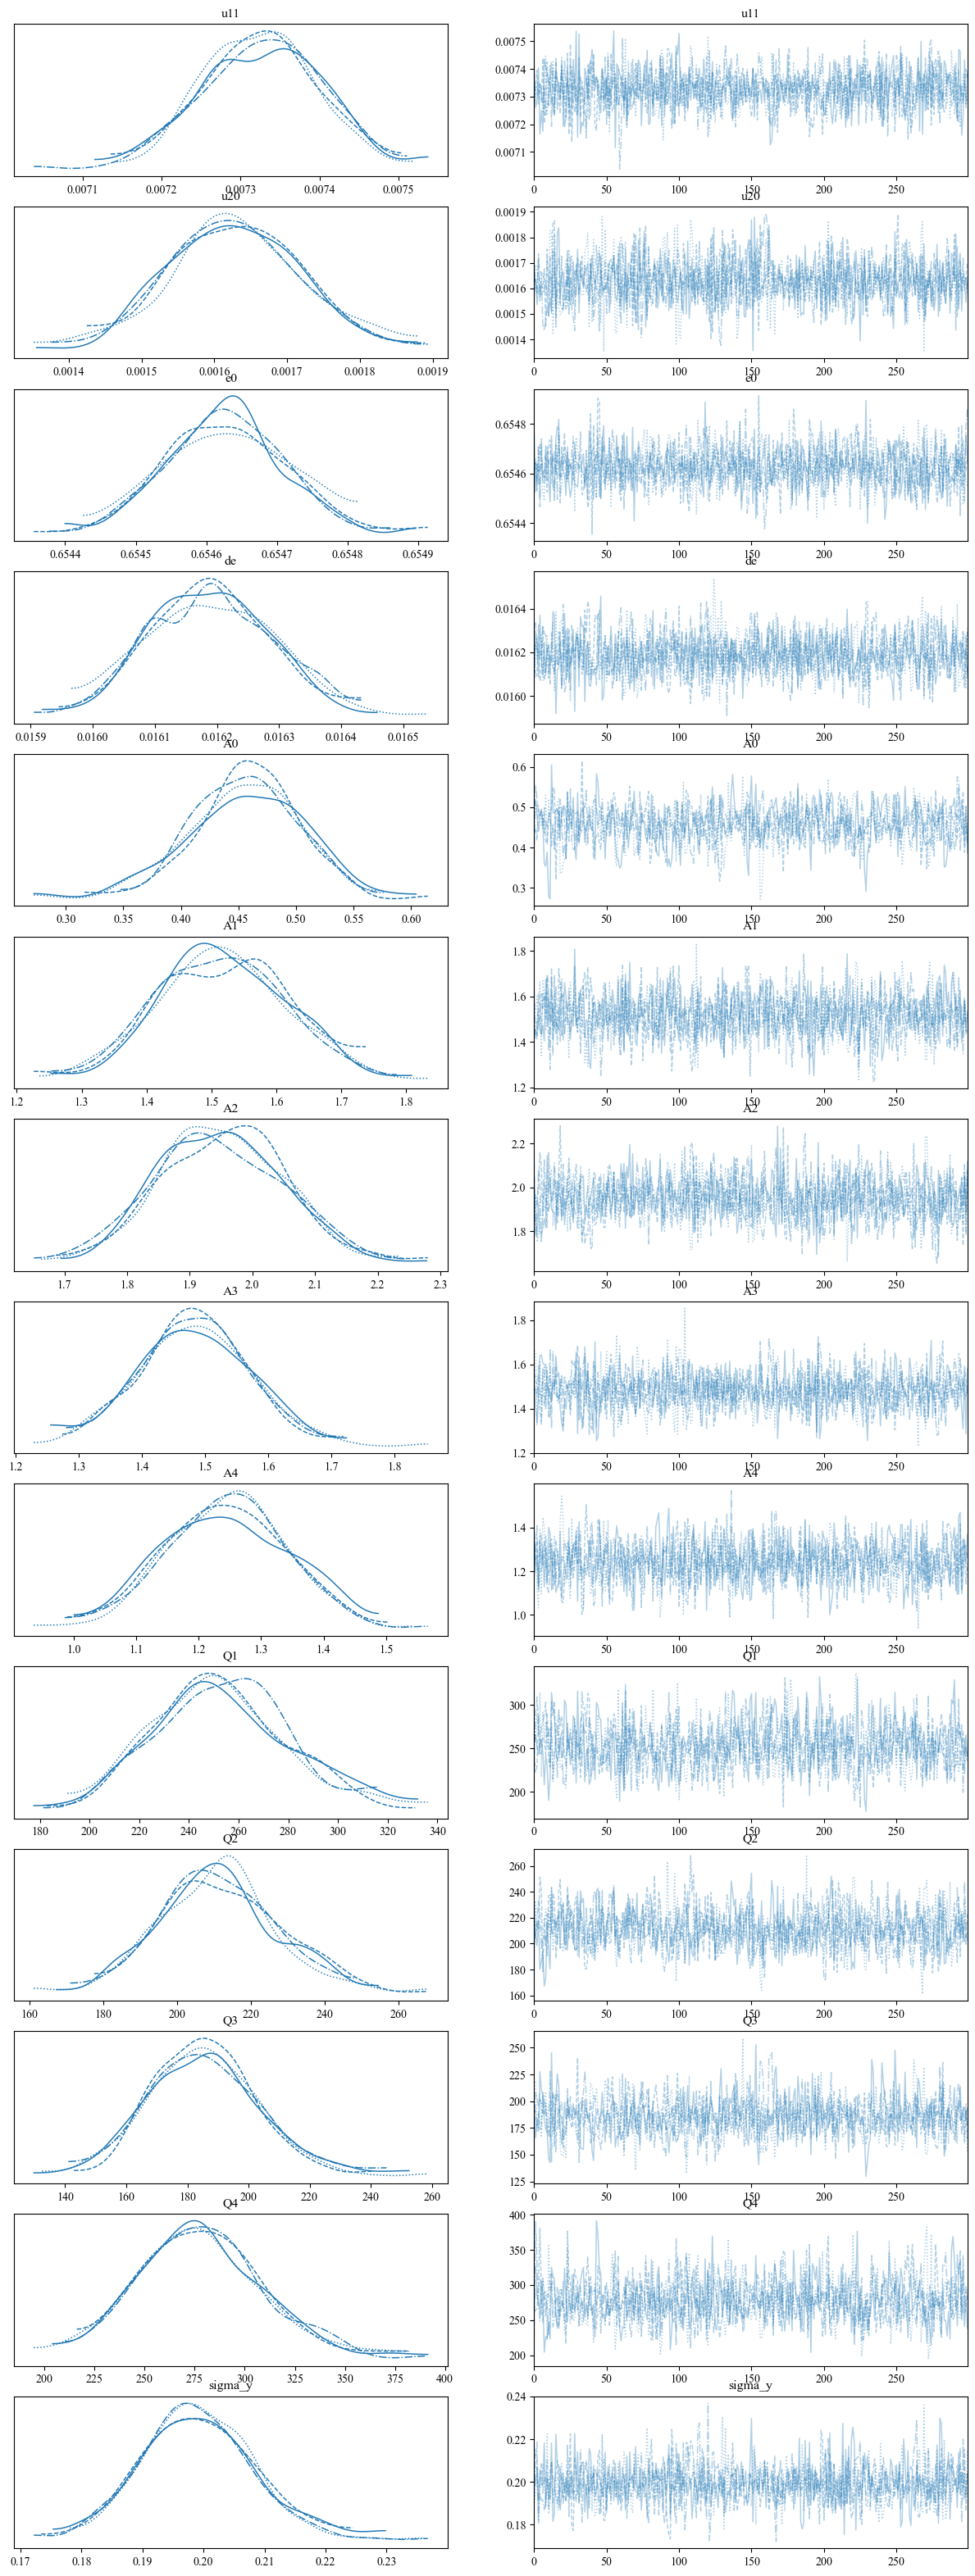

In [84]:
## attempt with more physical priors
#guess the prior bounds
prior_A = [0.5, 2.5]
prior_W = [0.001, 0.03]
Q = [1/200]
priors_2 = {'u11':('Normal', [0.0074, 0.0002]),
               'u20':('Normal', [0.0017, 0.0001]),
               'e0':('Uniform', [0.64, 0.67]),
               'de':('Uniform', [0.005, 0.025]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', [1/1.6]),
               'A2':('Exponential', [1/1.6]),
               'A3':('Exponential', [1/1.6]),
               'A4':('Exponential', [1/1.6]),
               'Q1':('Exponential', Q ), 
               'Q2':('Exponential', Q ),
               'Q3':('Exponential', Q ),
               'Q4':('Exponential', Q ),
               'sigma_y':('Exponential', [1/0.2])}

#create the model 
ham_model = Hamiltonian_model(real_data, priors_2)
with ham_model:
    idata = pm.sample(300)

az.plot_trace(idata, figsize=(15,40));

mean         sd      hdi_3%     hdi_97%  mcse_mean   mcse_sd  \
u11        0.007326   0.000074    0.007191    0.007457   0.000002  0.000001   
u20        0.001629   0.000092    0.001452    0.001802   0.000002  0.000002   
e0         0.654627   0.000084    0.654467    0.654775   0.000002  0.000001   
de         0.016189   0.000098    0.016015    0.016370   0.000003  0.000002   
A0         0.456410   0.047346    0.368227    0.540182   0.001591  0.001126   
A1         1.517229   0.099026    1.343244    1.704882   0.002501  0.001769   
A2         1.949792   0.099628    1.762831    2.126950   0.002626  0.001858   
A3         1.483020   0.086886    1.315037    1.643169   0.002189  0.001548   
A4         1.243959   0.096567    1.061697    1.417343   0.002453  0.001740   
Q1       252.766323  26.867755  206.961687  307.646337   0.857185  0.606302   
Q2       211.324448  15.884848  184.896033  243.934219   0.472128  0.333931   
Q3       185.617883  18.184780  149.776256  218.710646   0.540249  0.382112   
Q4       278.421111  31.357503  220.182931  337.432237   0.912033  0.648806   
sigma_y    0.199238   0.009422    0.179919    0.215621   0.000223  0.000159   

            ess_bulk     ess_tail     r_hat  
u11      1886.269075   986.822676  1.001599  
u20      1826.117167   829.228751  1.003703  
e0       1788.437250  1061.998231  1.003175  
de       1541.242412   619.215122  1.002786  
A0        925.141178   593.523269  1.003668  
A1       1570.849033  1020.474179  1.005315  
A2       1423.647899   832.071953  1.002522  
A3       1566.601233   868.393064  1.004327  
A4       1540.405632   940.178444  1.007173  
Q1        974.762184   979.332601  1.001168  
Q2       1144.534308   824.917610  1.006320  
Q3       1135.897782   820.874906  1.004347  
Q4       1190.396415   963.612397  0.998534  
sigma_y  1797.398198   767.815074  1.002499

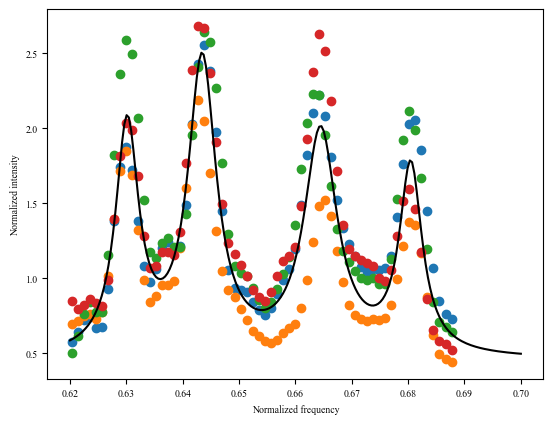

In [85]:
#summary the fitting results
summary = az.summary(idata, round_to=8)
display(summary)
#plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y = summary['mean'].values
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]
model_predictions = prediction_model(theta, np.linspace(0.62,0.70,200))
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(freq, intensity.T, 'o')
plt.plot(np.linspace(0.62,0.70,200), model_predictions,'k')

In [86]:
az.to_netcdf(idata, 'idata_0p055.nc')

'idata_0p055.nc'

## 0.60

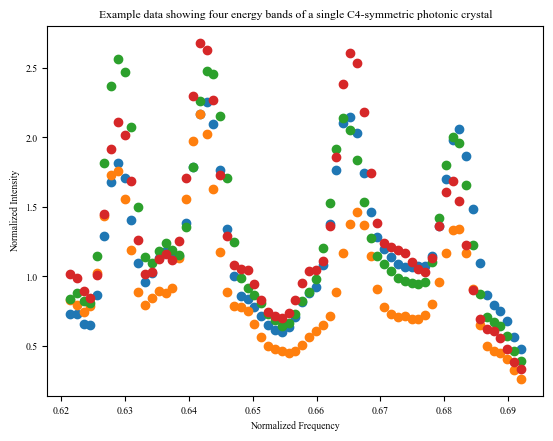

In [92]:
# load 0.55
real_data = io_data.load_data('photonic_hamiltonian\data\expdata4_GM0p06.nc')
freq = real_data['normf'].to_numpy()
intensity = np.zeros((4,len(freq)))
intensity[:] = [real_data[name].to_numpy() for name in ['y1', 'y2', 'y3', 'y4']]
plt.plot(freq, intensity.T, 'o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')
plt.show()

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, Q1, Q2, Q3, Q4, sigma_y]


Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 109 seconds.


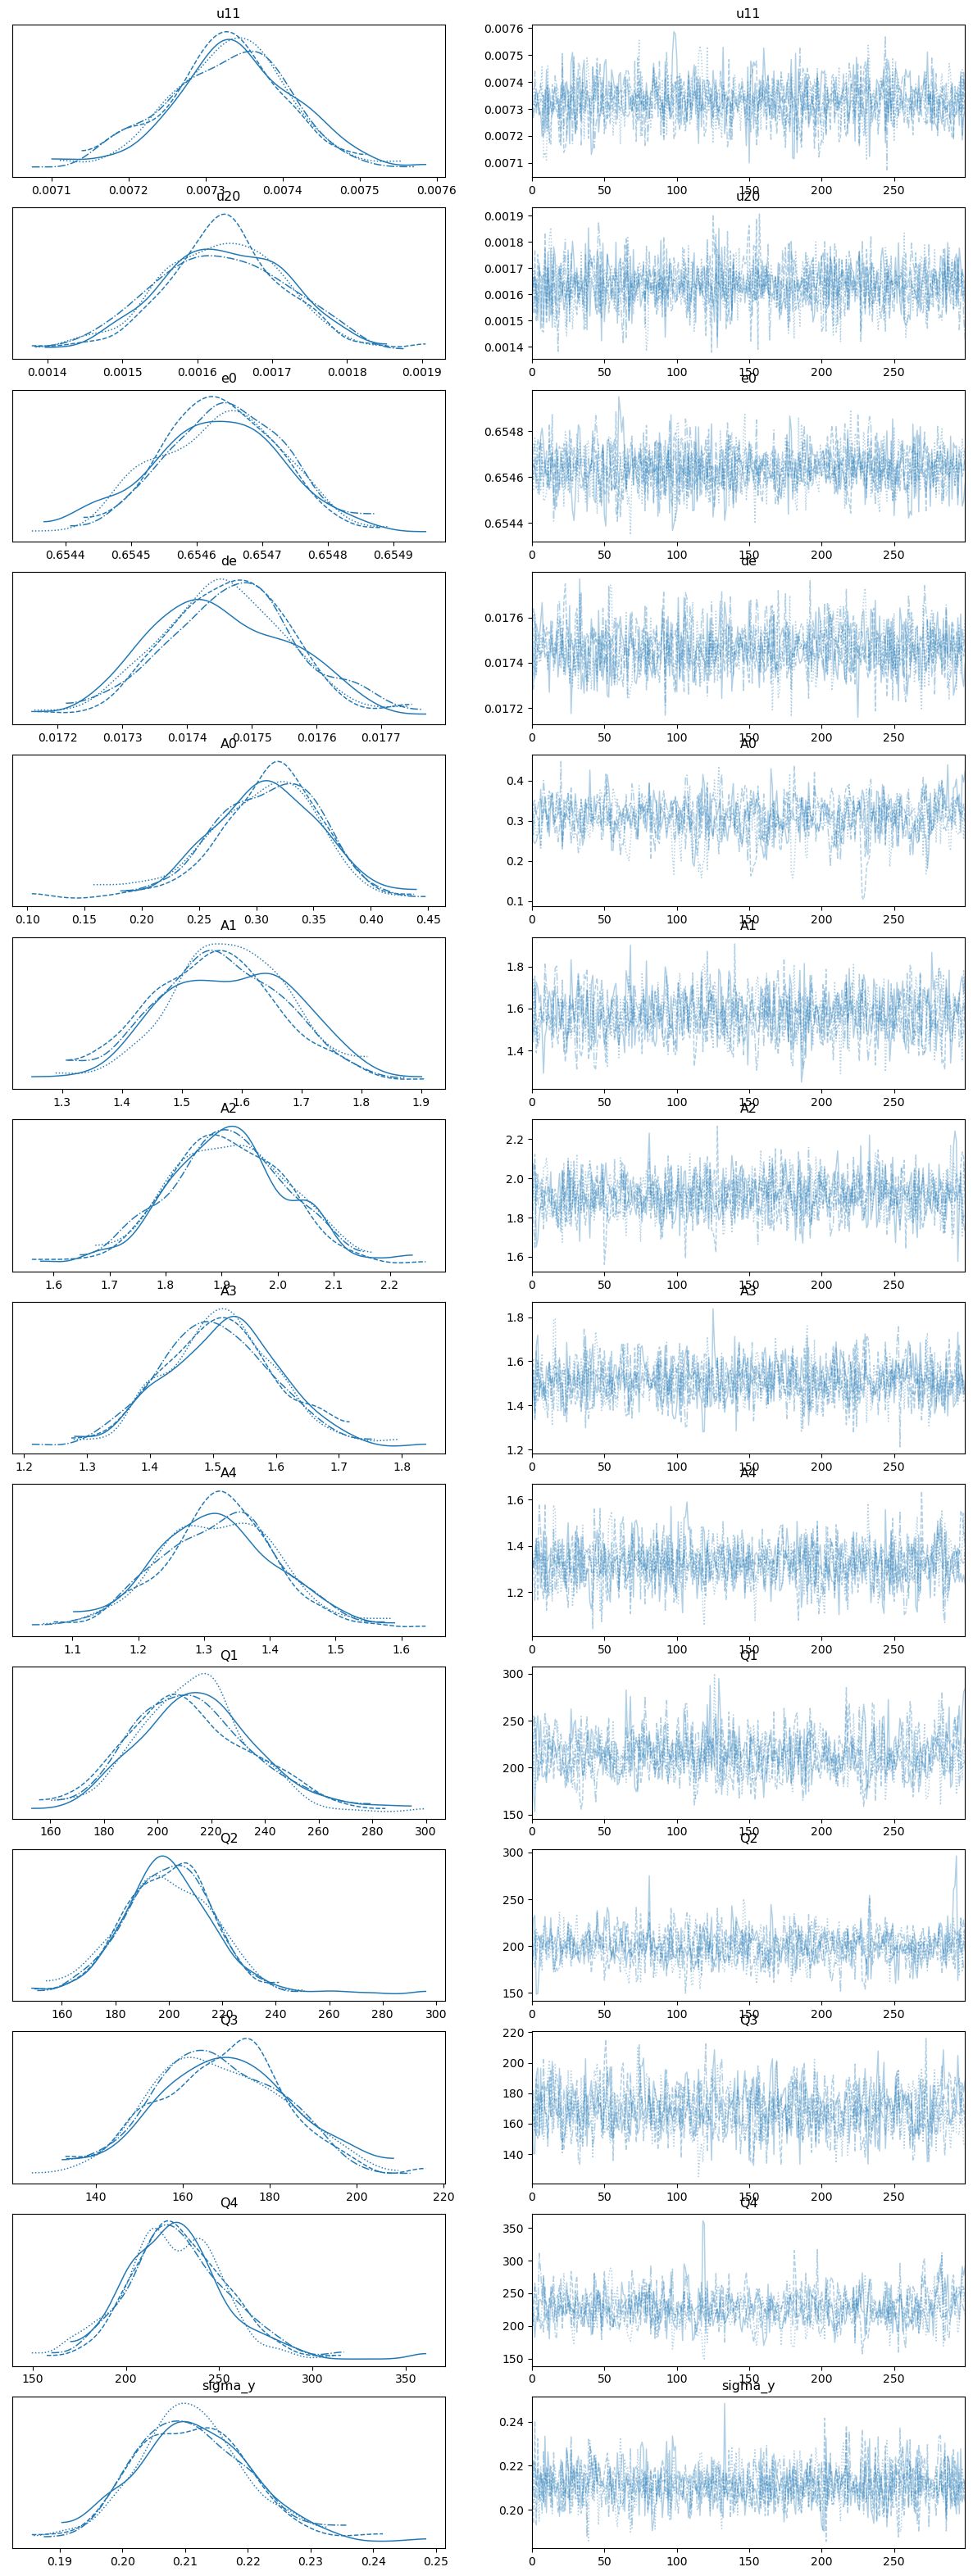

In [65]:
## attempt with more physical priors
#guess the prior bounds
prior_A = [0.5, 2.5]
prior_W = [0.001, 0.03]
Q = [1/200]
priors_2 = {'u11':('Normal', [0.0074, 0.0002]),
               'u20':('Normal', [0.0017, 0.0001]),
               'e0':('Uniform', [0.64, 0.67]),
               'de':('Uniform', [0.005, 0.025]),
               'A0':('Exponential', [1/0.3]),
               'A1':('Exponential', [1/1.6]),
               'A2':('Exponential', [1/1.6]),
               'A3':('Exponential', [1/1.6]),
               'A4':('Exponential', [1/1.6]),
               'Q1':('Exponential', Q ), 
               'Q2':('Exponential', Q ),
               'Q3':('Exponential', Q ),
               'Q4':('Exponential', Q ),
               'sigma_y':('Exponential', [1/0.2])}

#create the model 
ham_model = Hamiltonian_model(real_data, priors_2)
with ham_model:
    idata = pm.sample(300)

az.plot_trace(idata, figsize=(15,40));

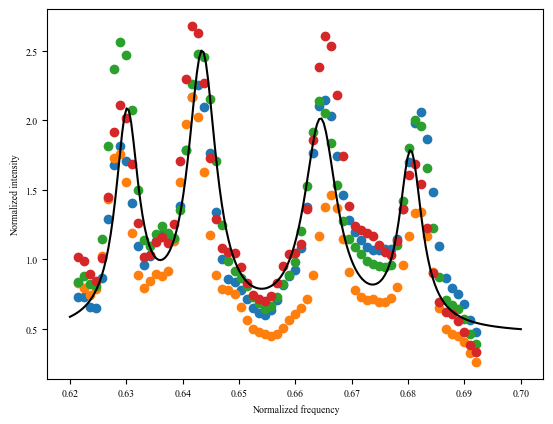

In [93]:
#summary the fitting results
idata = io_data.load_data('idata_0p06.nc')
# summary = az.summary(idata, round_to=8)
# display(summary)
### plot data with the fitting curve
u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4, sigma_y = summary['mean'].values
theta = [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]
model_predictions = prediction_model(theta, np.linspace(0.62,0.70,200))
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.plot(freq, intensity.T, 'o')
plt.plot(np.linspace(0.62,0.70,200), model_predictions,'k')

In [68]:
az.to_netcdf(idata, 'idata_0p06.nc')

'idata_0p06.nc'

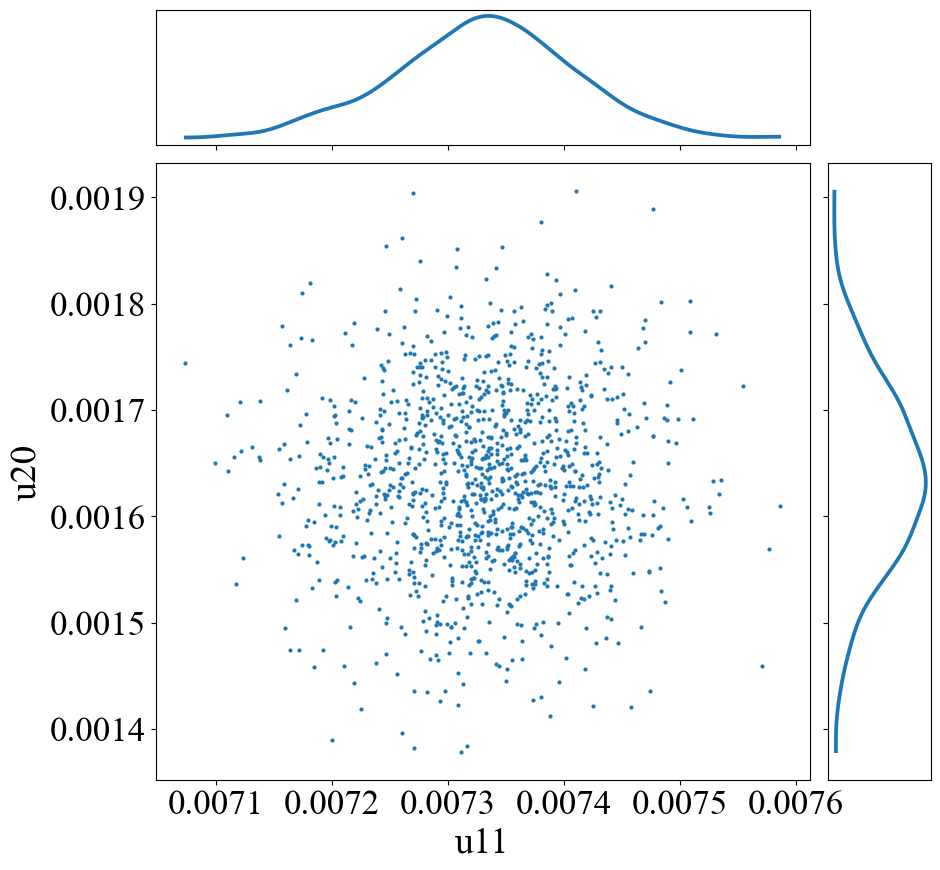

In [72]:
from matplotlib import rcParams
font = {'family' : 'Times New Roman',
         'weight' : 'normal',
         'size' : 7,
         }
confont = {
           'font.family' : 'serif',
           'mathtext.fontset':'stix',
           'font.serif':'Times New Roman',
           'font.size' : 7,
         }
rcParams.update(confont)
ff = az.plot_pair(idata,var_names=["u11", "u20"],marginals=True,figsize=(10, 10))
plt.savefig('k0p06_v2.png', dpi = 300,bbox_inches = 'tight')